In [ ]:
!pip install pyspark==3.4.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.1/311.1 MB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.2-py2.py3-none-any.whl size=311619833 sha256=56094ad0bc4899166b2aab58bfda85d18fbdab4b3e8377c2bf749b0de50f1a71
  Stored in directory: /root/.cache/pip/wheels/ae/78/cb/924eaddf18fb5bd07b68d76b6f706674e120883faa620a8d12
Successfully built pyspark
  Attempting uninstall: pyspark
    Found existing installation: pyspark 3.5.5
    Uninstalling pyspark-3.5.5:
      Successfully uninstalled pyspark-3.5.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-spark-connect 0.5.2 requires pyspark>=3.5, but you have pyspark 3.4.2 which is incompatible.


In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("Spark Graphframes").config("spark.jars.packages", "graphframes:graphframes:0.8.3-spark3.4-s_2.12").getOrCreate()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

parquet_path = "/content/drive/MyDrive/pubmed_data/df_pubmed.parquet"

df_pubmed = spark.read.parquet(parquet_path)

df_pubmed.show()

Mounted at /content/drive
+--------+--------------------+--------------------+----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+---------------+--------------------+-------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------+--------+--------+----------------------+
|    PMID|               Title|            Abstract|Year|             Journal|     PublicationType|        Author_Names|            Keywords|        MeshHeadings|           Chemicals|          References|Reference_Count|             CitedBy|CitedBy_Count|     abstract_tokens|     keywords_tokens|         mesh_tokens|     chemical_tokens|      cleaned_tokens|      stemmed_tokens|BP_count|MF_count|CC_count|matched_go_terms_clean|
+--------+--------------------+--------------------+----+--------------------+--------------------+-----------

In [ ]:
df_pubmed.count()

24919

In [ ]:
df_pubmed.show(truncate=False)

+--------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
df_pubmed.columns

['PMID',
 'Title',
 'Abstract',
 'Year',
 'Journal',
 'PublicationType',
 'Author_Names',
 'Keywords',
 'MeshHeadings',
 'Chemicals',
 'References',
 'Reference_Count',
 'CitedBy',
 'CitedBy_Count',
 'abstract_tokens',
 'keywords_tokens',
 'mesh_tokens',
 'chemical_tokens',
 'cleaned_tokens',
 'stemmed_tokens',
 'BP_count',
 'MF_count',
 'CC_count',
 'matched_go_terms_clean']

In [ ]:
from pyspark.sql.functions import explode, col, lit
from functools import reduce
from pyspark.sql.functions import *
from graphframes import *

edges_df = df_pubmed.select("PMID", explode("CitedBy").alias("citing_PMID")) \
             .withColumnRenamed("PMID", "src") \
             .withColumnRenamed("citing_PMID", "dst")

pmid_vertices = df_pubmed.select("PMID").distinct().withColumnRenamed("PMID", "id")
citing_vertices = df_pubmed.select(explode("CitedBy").alias("id")).distinct()
vertices_df = pmid_vertices.union(citing_vertices).distinct().withColumn("type", lit("paper"))

graph = GraphFrame(vertices_df, edges_df)

In this task, we constructed a directed citation graph from a PubMed-based dataset by linking each paper's PMID with the papers that cited it, as listed in the CitedBy field. Using PySpark and GraphFrames, we defined edges where each source (src) paper is the one being cited, and each destination (dst) paper is the one that cited it. We then created vertices for all unique PMIDs, whether they appeared as original papers or only as citing papers. This graph enables the analysis of citation patterns and paper influence within the dataset, even if full metadata is missing for some cited paper

In [ ]:
def visualize_citation_graph(graph_frame, pmid, node_size=2800):
    import networkx as nx
    import matplotlib.pyplot as plt
    import numpy as np

    cited_edges = graph_frame.edges.filter(f"src = '{pmid}'")
    edges_pd = cited_edges.toPandas()

    if edges_pd.empty:
        print(f"No citations found for PMID {pmid}")
        return

    nx_graph = nx.DiGraph()
    for _, row in edges_pd.iterrows():
        nx_graph.add_edge(row['src'], row['dst'])

    pos = {pmid: np.array([0, 0])}
    angle_step = 2 * np.pi / len(nx_graph[pmid])
    radius = 2.5
    for i, neighbor in enumerate(nx_graph[pmid]):
        angle = i * angle_step
        x = radius * np.cos(angle)
        y = radius * np.sin(angle)
        pos[neighbor] = np.array([x, y])

    # Visual styles
    node_colors = ['orange' if node == pmid else 'lightgreen' for node in nx_graph.nodes()]
    node_sizes = [node_size if node == pmid else node_size * 1 for node in nx_graph.nodes()]

    plt.figure(figsize=(8, 8))
    nx.draw_networkx_nodes(nx_graph, pos, node_size=node_sizes, node_color=node_colors)
    nx.draw_networkx_labels(nx_graph, pos, font_size=10, font_weight='bold')
    nx.draw_networkx_edges(nx_graph, pos, arrows=True, arrowstyle='->', edge_color='black')

    plt.title(f"Citation Network for PMID {pmid}")
    plt.axis('off')
    plt.tight_layout()
    plt.show()


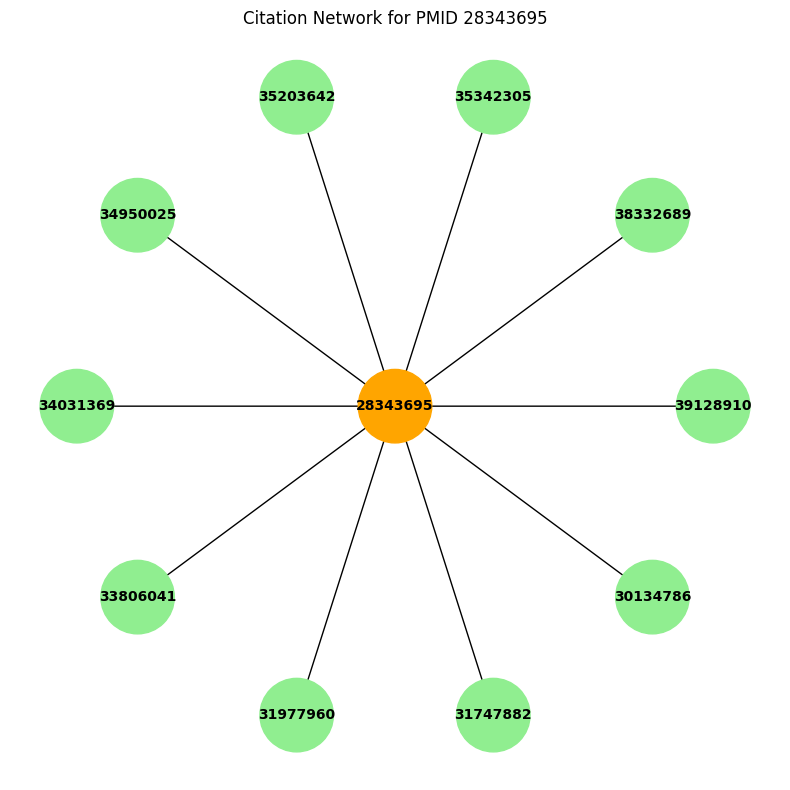

In [ ]:
visualize_citation_graph(graph, "28343695")

In this analysis, we constructed and visualized a directed citation graph for PubMed articles based on the CitedBy field. Each node represents a scientific publication identified by its PMID, and directed edges point from the cited paper to the papers that have cited it. Using PySpark and GraphFrames, we extracted citation relationships from the dataset and visualized the citation network of a specific paper (PMID: 28343695) using NetworkX and Matplotlib. The central orange node represents the selected paper, while the surrounding green nodes are the articles that cite it. The visualization reveals that PMID: 28343695 has been cited by 10 different papers, demonstrating its scholarly influence and role within the literature network. This kind of graph-based insight can support impact assessment, topic clustering, and citation-based discovery.

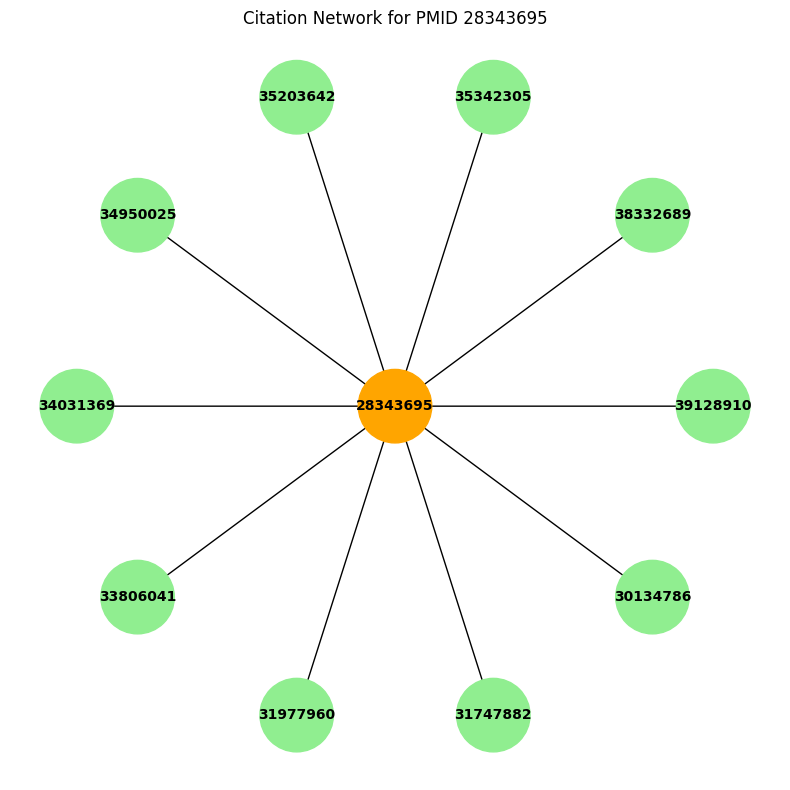

In [ ]:
visualize_citation_graph(graph, "28343695")

In this case, the function visualize_citation_graph(graph, "28343695") did not produce a graph because the specified PMID (28343695) does not appear in the filtered citation graph. This is expected behavior, as the updated graph only includes citation edges where both the citing and cited papers exist in the dataset. Since 28343695 is not present in the PMID column of the dataset after filtering, it has no valid connections, and therefore no citations to display in the graph.

In [ ]:
citing_pmids = df_pubmed.select(explode("CitedBy").alias("pmid")).distinct()

all_pmids = df_pubmed.select("PMID").distinct()

valid_pmids = citing_pmids.join(all_pmids, citing_pmids["pmid"] == all_pmids["PMID"], "inner") \
                           .select(citing_pmids["pmid"])

valid_pmids.show(truncate=False)


+--------+
|pmid    |
+--------+
|28373364|
|28351153|
|28350901|
|28360750|
|28351939|
|28347023|
|28354866|
|28344235|
|28348254|
|28354940|
|28357384|
|28373013|
|28361497|
|28366966|
|28361260|
|28348344|
|28369261|
|28356872|
|28344272|
|28353160|
+--------+
only showing top 20 rows



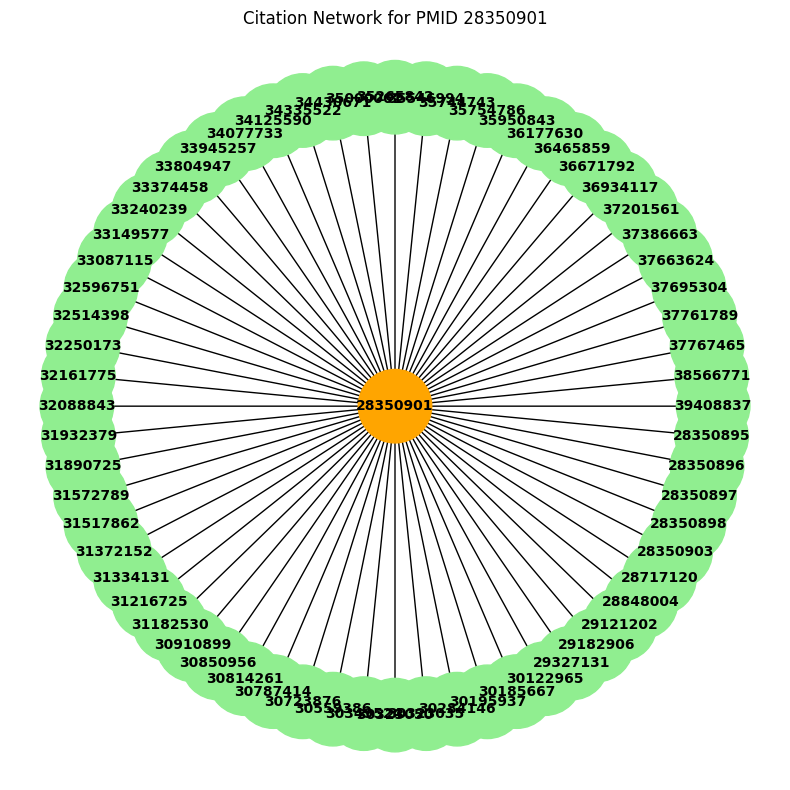

In [ ]:
visualize_citation_graph(graph, "28350901")

In [ ]:
from pyspark.sql.functions import explode, array_contains

df_pubmed.filter(df_pubmed.PMID == "28350901").select(explode("CitedBy")).show(500)

+--------+
|     col|
+--------+
|39408837|
|38566771|
|37767465|
|37761789|
|37695304|
|37663624|
|37386663|
|37201561|
|36934117|
|36671792|
|36465859|
|36177630|
|35950843|
|35754786|
|35744743|
|35546994|
|35265842|
|35000061|
|34430671|
|34335522|
|34125590|
|34077733|
|33945257|
|33804947|
|33374458|
|33240239|
|33149577|
|33087115|
|32596751|
|32514398|
|32250173|
|32161775|
|32088843|
|31932379|
|31890725|
|31572789|
|31517862|
|31372152|
|31334131|
|31216725|
|31182530|
|30910899|
|30850956|
|30814261|
|30787414|
|30723876|
|30559386|
|30349524|
|30323050|
|30323035|
|30284146|
|30195937|
|30185667|
|30122965|
|29327131|
|29182906|
|29121202|
|28848004|
|28717120|
|28350903|
|28350898|
|28350897|
|28350896|
|28350895|
+--------+



In [ ]:
from pyspark.sql.functions import explode, array_contains, collect_list

cited_by_pmids_df = df_pubmed.filter(df_pubmed.PMID == "28350901").select(explode("CitedBy").alias("cited_pmid"))

all_pmids_df = df_pubmed.select("PMID").distinct()

common_pmids_df = cited_by_pmids_df.join(all_pmids_df, cited_by_pmids_df.cited_pmid == all_pmids_df.PMID, "inner")

common_pmids_list = common_pmids_df.select("cited_pmid").rdd.flatMap(lambda x: x).collect()
print("Common PMIDs:", common_pmids_list)

Common PMIDs: ['28350903', '28350898', '28350897', '28350896']


We identified the PMIDs of articles that cite PMID 28350901 and are also present as distinct entries within the df_pubmed DataFrame. The PMID 28350901 was successfully identified as a connected publication within the dataset, as it appears in the CitedBy lists of other papers and is also present as a full entry in the dataset. This allows us to visualize its local citation network, which includes direct connections with PMIDs 28350896, 28350897, 28350898, and 28350903.

In [ ]:
pmids_to_explore = ["28350901", "28350896", "28350897", "28350898", "28350903"]

df_citation_context = df_pubmed.filter(col("PMID").isin(pmids_to_explore))

In [ ]:
columns_to_view = [
    "PMID", "Title", "Abstract", "Journal", "Author_Names", "Chemicals",
    "Keywords", "MeshHeadings", "matched_go_terms_clean", "BP_count", "MF_count", "CC_count"
]

df_citation_context.select(columns_to_view).show(truncate=False)


+--------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

All 5 publications:

Appear in the same journal: Clinical Infectious Diseases

All papers mention “antibacterial resistance”, diagnostics, clinical trials, and network design The titles themselves show functional roles within ARLG:

28350901 = Research priorities + accomplishments

28350903 = Focus on diagnostics

28350896 = Progress report on the initiative

28350897 = Network infrastructure (Leadership and Operations Center)

28350898 = Laboratory and biorepository

Robert A. Bonomo, Scott R. Evans, Barry N. Kreiswirth appear across multiple papers. Suggests internal citation between contributors to the ARLG — typical in coordinated consortia work.

In [ ]:
def visualize_citation_lineage(df_pubmed, start_pmid, depth=2):
    import matplotlib.pyplot as plt
    import networkx as nx
    from pyspark.sql.functions import col, explode

    # Collect all valid PMIDs from dataset
    valid_pmids = set(df_pubmed.select("PMID").rdd.flatMap(lambda x: x).collect())

    # Initialize edge list
    edges = []
    current_pmids = [start_pmid]

    for d in range(depth):
        # Get cited-by for current_pmids
        cited_df = df_pubmed.filter(col("PMID").isin(current_pmids)) \
                            .select(col("PMID").alias("source"), explode("CitedBy").alias("target"))

        # Filter only valid PMIDs (existing in dataset)
        cited_df = cited_df.filter(col("target").isin(valid_pmids))
        new_edges = [(str(row['source']), str(row['target'])) for row in cited_df.collect()]
        edges.extend(new_edges)

        # Update for next level
        current_pmids = [target for _, target in new_edges]

        # Avoid infinite loops
        if not current_pmids:
            break

    # Build graph
    G = nx.DiGraph()
    G.add_edges_from(edges)

    # Visualization
    pos = nx.spring_layout(G, seed=42)
    node_colors = ['orange' if node == str(start_pmid) else 'lightgreen' for node in G.nodes()]
    plt.figure(figsize=(12, 12))
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=2800)
    nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')
    nx.draw_networkx_edges(G, pos, arrows=True)
    plt.title(f"Citation Lineage Tree for PMID {start_pmid} (Depth {depth})")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    return G  # Return graph if further analysis is needed


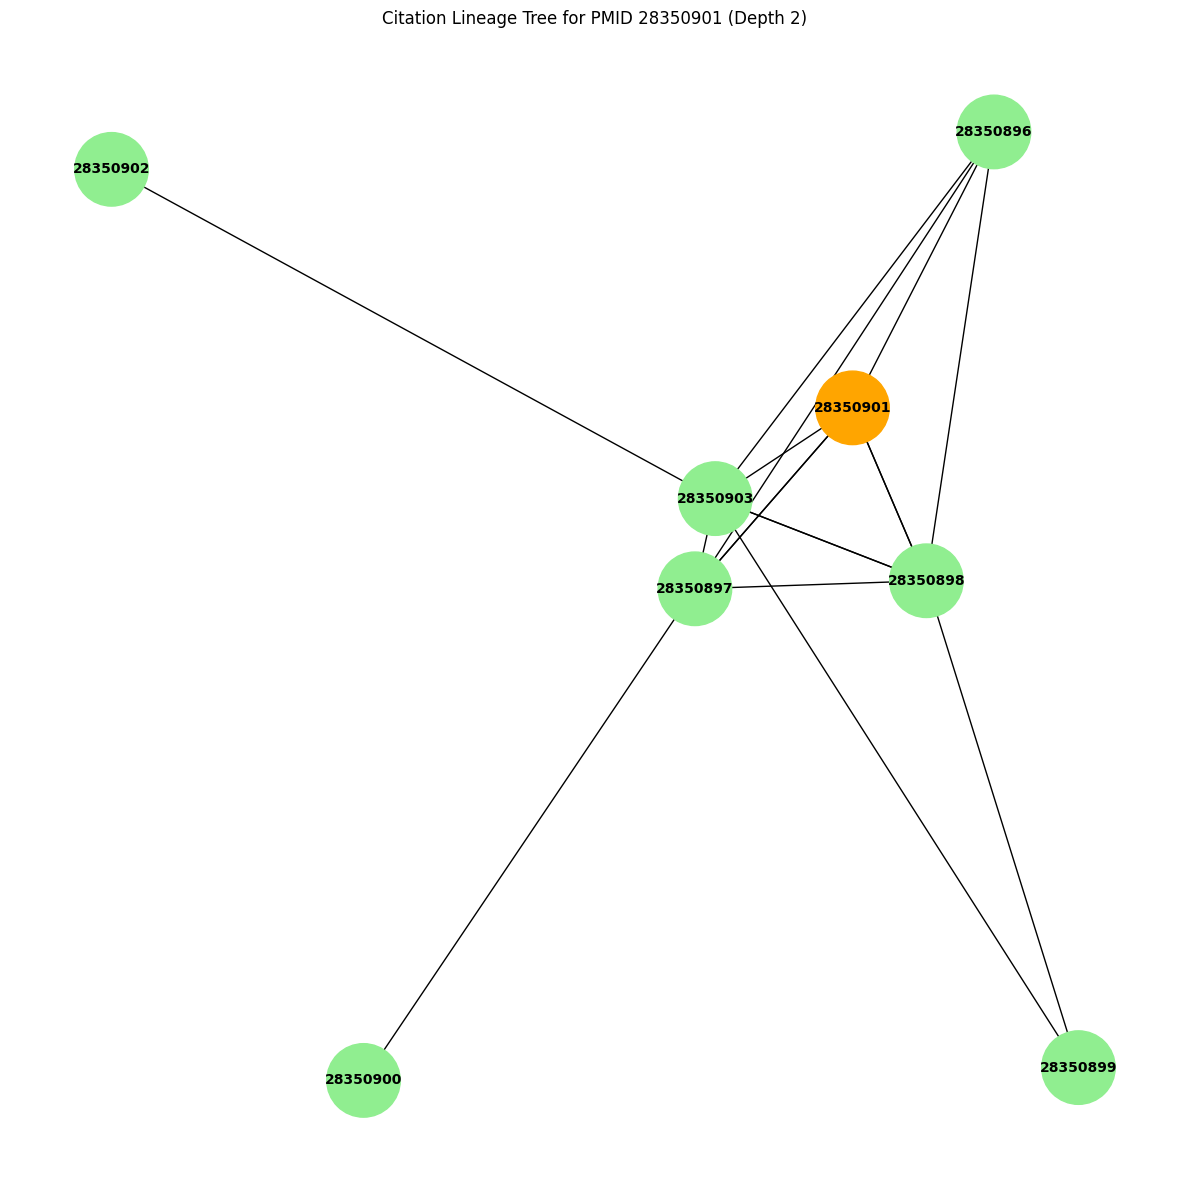

In [ ]:
# Παράδειγμα χρήσης:
G = visualize_citation_lineage(df_pubmed, start_pmid="28350901", depth=2)


In [ ]:
def visualize_citation_lineage(df_pubmed, start_pmid, depth=2):
    import matplotlib.pyplot as plt
    import networkx as nx
    from pyspark.sql.functions import col, explode

    # Step 1: Collect valid PMIDs
    valid_pmids = set(df_pubmed.select("PMID").rdd.flatMap(lambda x: x).collect())

    # Step 2: Initialize
    edges = []
    current_pmids = [start_pmid]
    all_nodes = {str(start_pmid): 0}  # node: depth

    for d in range(1, depth + 1):
        cited_df = df_pubmed.filter(col("PMID").isin(current_pmids)) \
                            .select(col("PMID").alias("source"), explode("CitedBy").alias("target")) \
                            .filter(col("target").isin(valid_pmids))

        new_edges = [(str(row['source']), str(row['target'])) for row in cited_df.collect()]
        edges.extend(new_edges)

        # Track depth per node
        for _, target in new_edges:
            if target not in all_nodes:
                all_nodes[target] = d

        current_pmids = [target for _, target in new_edges]
        if not current_pmids:
            break

    # Step 3: Build graph
    G = nx.DiGraph()
    G.add_edges_from(edges)

    # Step 4: Coloring based on depth
    color_map = {0: 'orange', 1: 'gold', 2: 'lightgreen'}
    node_colors = [color_map.get(all_nodes.get(node, 2), 'gray') for node in G.nodes()]

    # Step 5: Visualization
    pos = nx.spring_layout(G, seed=42)
    plt.figure(figsize=(12, 12))
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=2800)
    nx.draw_networkx_labels(G, pos, font_size=9, font_weight='bold')
    nx.draw_networkx_edges(G, pos, arrows=True)

    # Legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='orange', edgecolor='black', label='Root PMID'),
        Patch(facecolor='gold', edgecolor='black', label='Citing PMID (Depth 1)'),
        Patch(facecolor='lightgreen', edgecolor='black', label='Citing of Citing (Depth 2)')
    ]
    plt.legend(handles=legend_elements, loc='lower right', fontsize=10)

    plt.title(f"Citation Lineage Tree for PMID {start_pmid} (Depth {depth})")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    return G


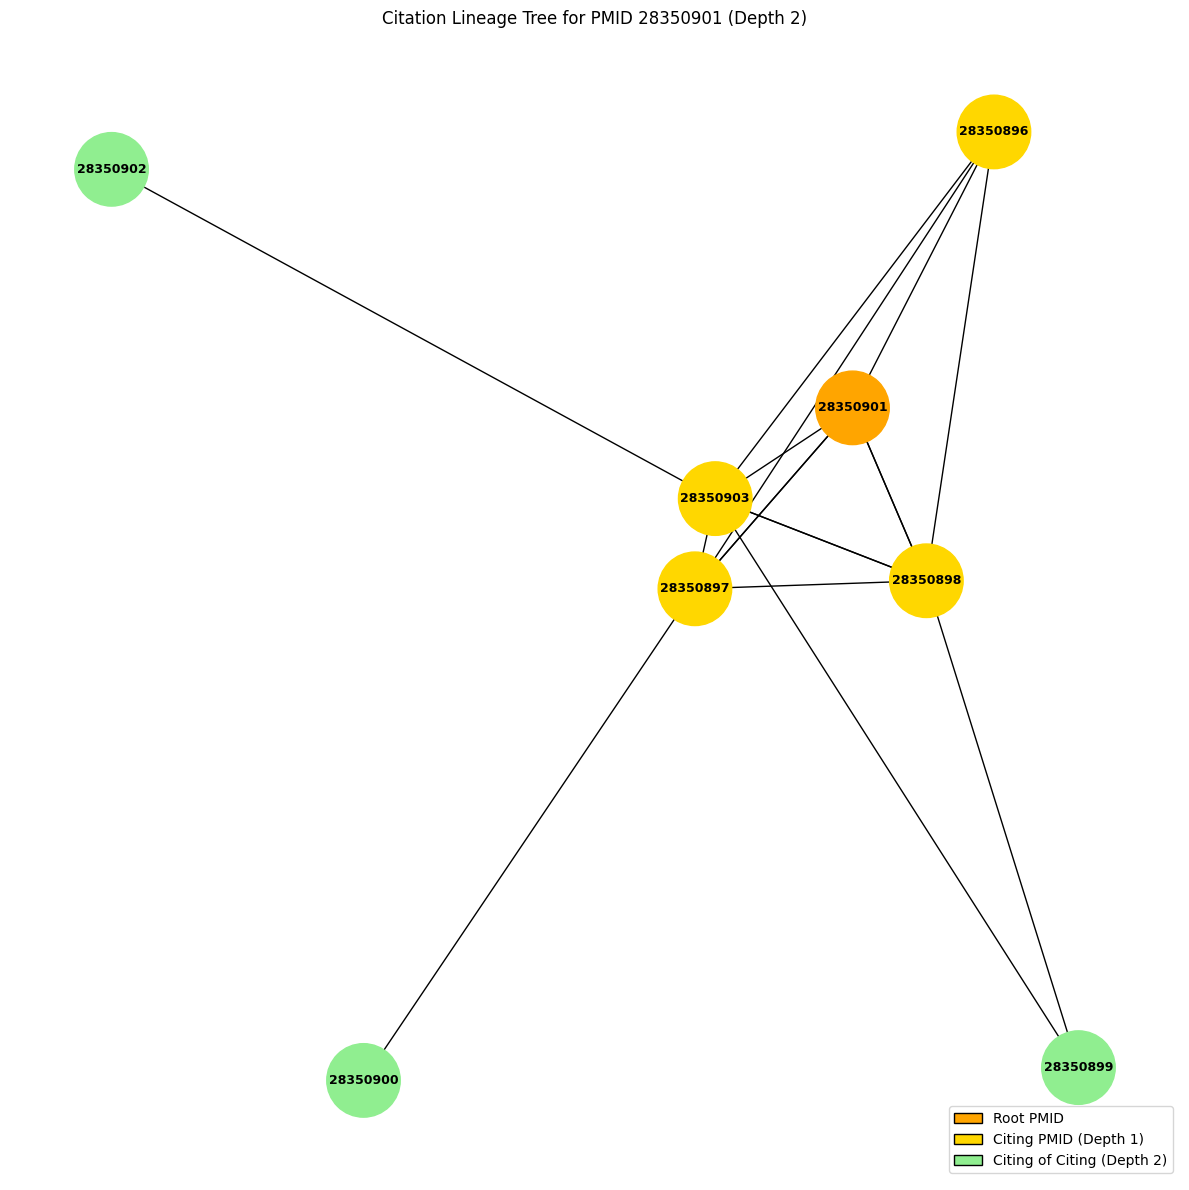

In [ ]:
G = visualize_citation_lineage(df_pubmed, start_pmid="28350901", depth=2)

🔶 Root Publication:
PMID 28350901: This is the central article under investigation, shown in orange in the graph. It is the starting point of the citation network.
🟡 Direct Citing Publications (Depth 1):
Articles that have directly cited PMID 28350901, shown in yellow:
PMID 28350896
PMID 28350897
PMID 28350898
PMID 28350903
🟢 Citations of Citers (Depth 2):
Example
PMID 28350900 — Cites 28350897, 28350898 where 28350897 cites 28350901

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd


In [ ]:
# 1. Get paper → authors mapping
author_papers = edges_df.select(col("src").alias("author"), col("dst").alias("paper"))

# 2. Self-join on same paper to get co-authors
coauthor_edges = author_papers.alias("a1").join(
    author_papers.alias("a2"),
    (col("a1.paper") == col("a2.paper")) & (col("a1.author") != col("a2.author"))
).select(
    col("a1.author").alias("src"),
    col("a2.author").alias("dst")
).distinct()


In [ ]:
# Vertices (authors only)
author_vertices_only = coauthor_edges.select("src").union(coauthor_edges.select("dst")).distinct().withColumn("id", col("src")).select("id")
author_vertices_only = author_vertices_only.withColumn("type", lit("author"))

# GraphFrame: author collaboration network
author_graph = GraphFrame(author_vertices_only, coauthor_edges)


In [ ]:
author_degrees = author_graph.degrees.orderBy(desc("degree"))
author_degrees.show(10, truncate=False)


+---------------------+------+
|id                   |degree|
+---------------------+------+
|                     |18    |
|Joellen M Schildkraut|18    |
|Christopher I Amos   |18    |
|Minouk J Schoemaker  |18    |
|Dale P Sandler       |18    |
|Tanja Pejovic        |18    |
|Heli Nevanlinna      |18    |
|James M Flanagan     |18    |
|Wendy K Chung        |18    |
|Stephen Chanock      |18    |
+---------------------+------+



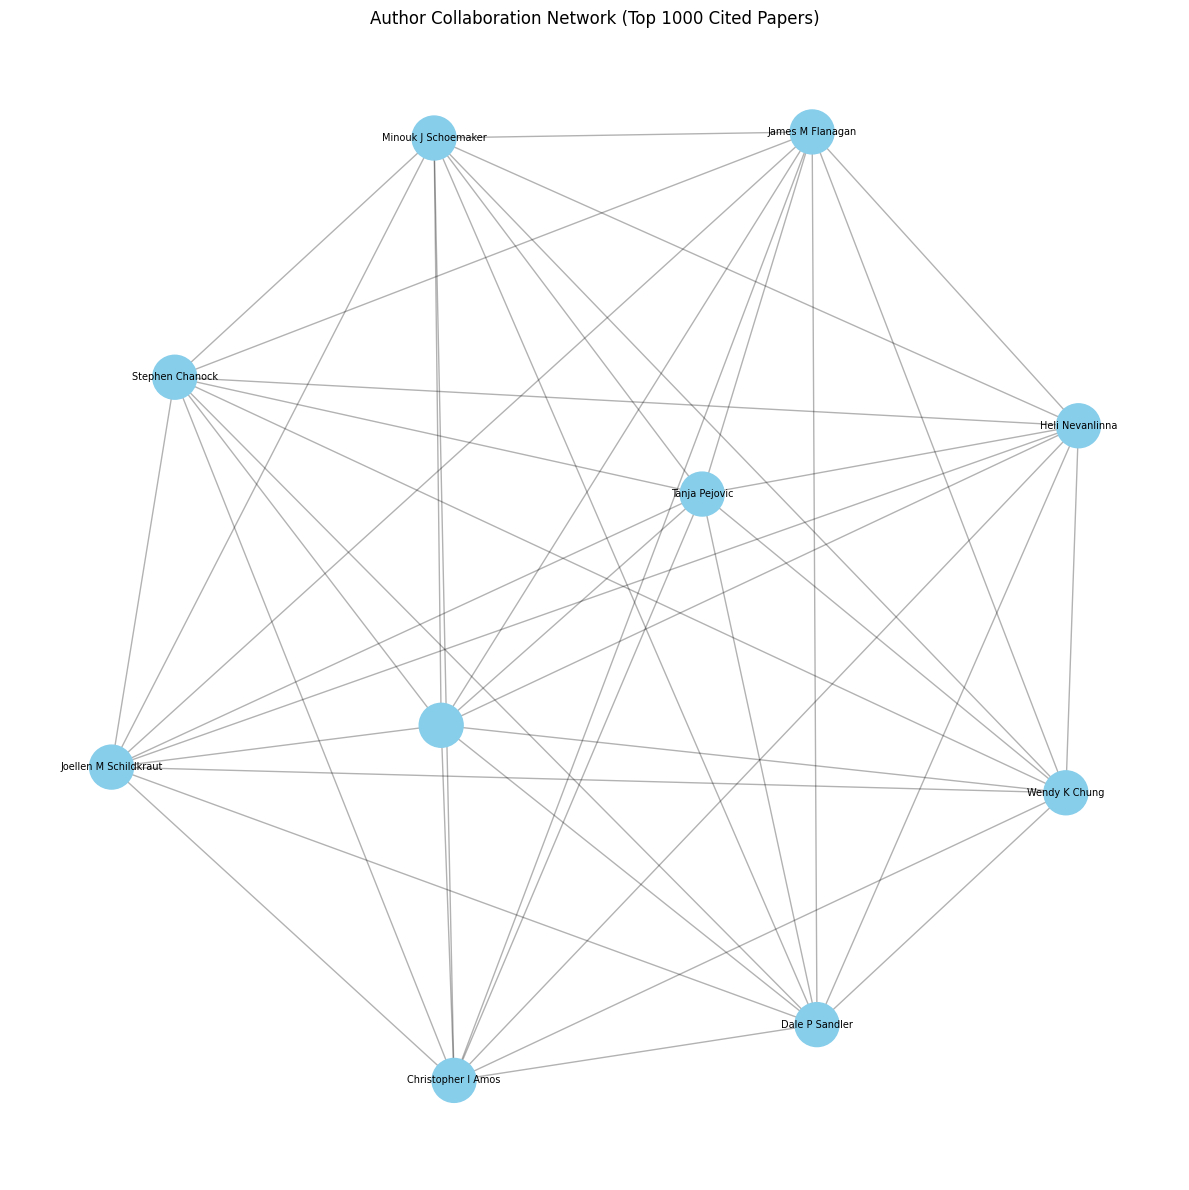

In [ ]:
# Convert to pandas
v_pd = author_graph.vertices.toPandas()
e_pd = author_graph.edges.toPandas()

# Build NetworkX graph
import networkx as nx
G = nx.Graph()
G.add_nodes_from(v_pd["id"].tolist())
G.add_edges_from(e_pd[["src", "dst"]].values.tolist())

# Node size = collaboration degree
degree_dict = dict(G.degree())
node_sizes = [100 + degree_dict[n] * 100 for n in G.nodes()]

# Draw
import matplotlib.pyplot as plt
pos = nx.spring_layout(G, seed=42)
plt.figure(figsize=(12, 12))
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='skyblue')
nx.draw_networkx_edges(G, pos, alpha=0.3)
nx.draw_networkx_labels(G, pos, font_size=7)
plt.title("Author Collaboration Network (Top 1000 Cited Papers)")
plt.axis('off')
plt.tight_layout()
plt.show()


In [ ]:
import networkx as nx
centrality = nx.eigenvector_centrality(G)
# Normalize for colormap
node_colors = [centrality[n] for n in G.nodes()]


In [ ]:
from collections import Counter

# Count co-authorships
edge_list = [tuple(sorted((r["src"], r["dst"]))) for r in e_pd.to_dict("records")]
edge_weights = Counter(edge_list)

# Add weighted edges
G_weighted = nx.Graph()
for (a1, a2), weight in edge_weights.items():
    G_weighted.add_edge(a1, a2, weight=weight)

# Draw edge width proportional to weight
edge_widths = [G_weighted[u][v]['weight'] for u, v in G_weighted.edges()]


In [ ]:
!pip install python-louvain

In [ ]:
!pip install python-louvain
import community.community_louvain as community_louvain
partition = community_louvain.best_partition(G)
colors = [partition[n] for n in G.nodes()]


{'James M Flanagan': Text(0.4080460088785464, 0.9385412416095369, 'James M Flanagan'),
 'Heli Nevanlinna': Text(0.9432291668209997, 0.3438906396577681, 'Heli Nevanlinna'),
 'Joellen M Schildkraut': Text(-1.0, -0.34678940898999433, 'Joellen M Schildkraut'),
 'Stephen Chanock': Text(-0.8729408951874096, 0.4421446485920259, 'Stephen Chanock'),
 'Tanja Pejovic': Text(0.18701487601789635, 0.20570883116806118, 'Tanja Pejovic'),
 'Minouk J Schoemaker': Text(-0.3518018984506692, 0.9262292596593948, 'Minouk J Schoemaker'),
 'Wendy K Chung': Text(0.9178928248984451, -0.39880446550243565, 'Wendy K Chung'),
 'Christopher I Amos': Text(-0.31165488588842266, -0.9808148980860291, 'Christopher I Amos'),
 '': Text(-0.3375106298022389, -0.26217776686311106, ''),
 'Dale P Sandler': Text(0.4177254327128518, -0.867928081245215, 'Dale P Sandler')}

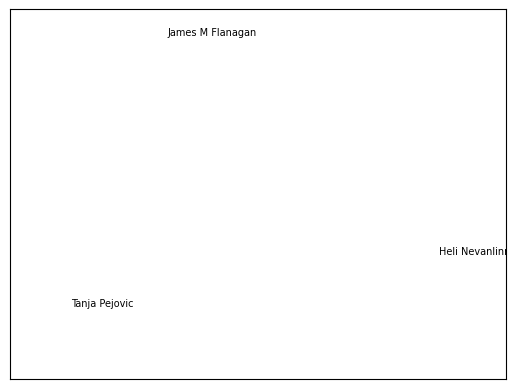

In [ ]:
labels = {n: n if centrality[n] > 0.15 else "" for n in G.nodes()}
nx.draw_networkx_labels(G, pos, labels, font_size=7)


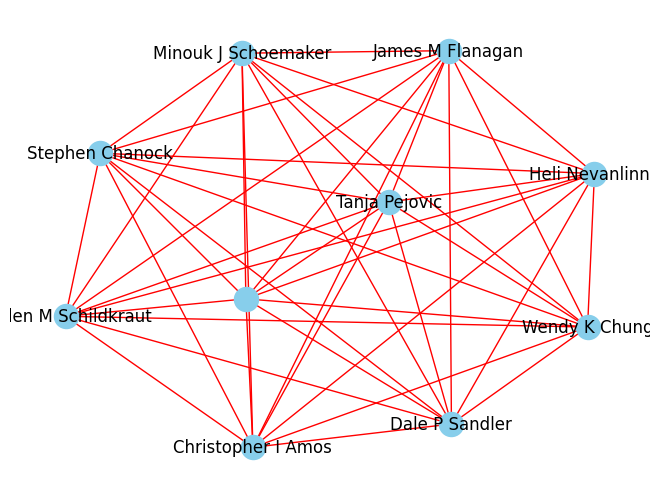

In [ ]:
ego = nx.ego_graph(G, "Tanja Pejovic", radius=50)
nx.draw(ego, pos, node_color='skyblue', edge_color='red', with_labels=True)


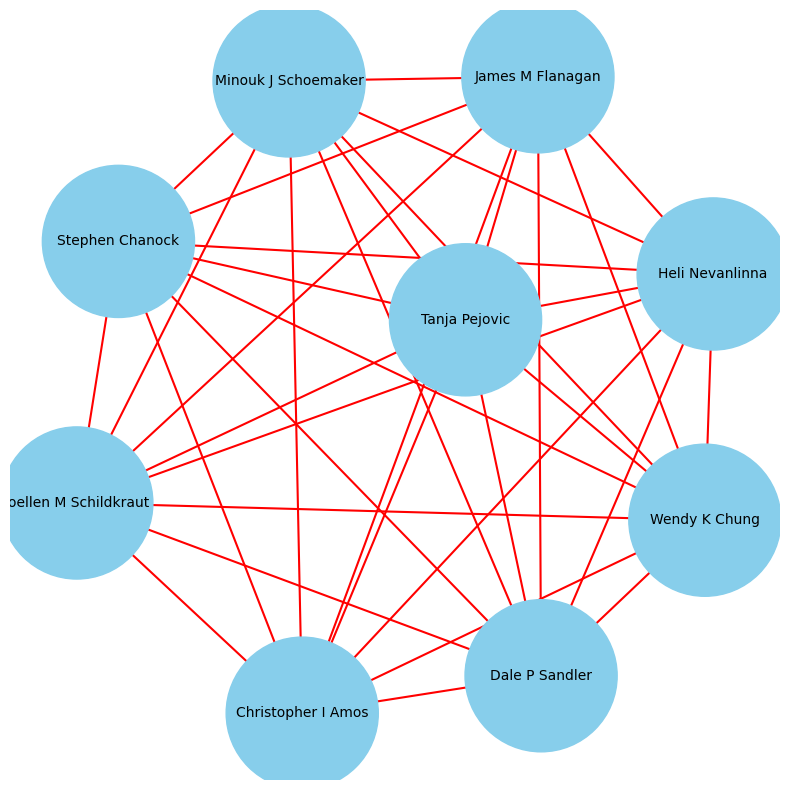

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

# Remove empty node from graph (if already built)
if '' in G:
    G.remove_node('')

plt.figure(figsize=(8, 8))
node_sizes = [G.degree(n) * 1500 for n in G.nodes()]  # Make nodes larger by degree

nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=node_sizes)
nx.draw_networkx_edges(G, pos, edge_color='red', width=1.5)
nx.draw_networkx_labels(G, pos, font_size=10)

plt.axis('off')
plt.tight_layout()
plt.show()
